# Modèle guide d'onde de McIntyre


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mvt_Helmholtz import *
import scipy.optimize as opt

$r(t-T) = -\alpha \delta(t-T)$

In [2]:
def retardT(L,c):
    '''Renvoie T le retard accumulé par l'onde
    en un aller-retour
    L : longueur du guide cylindrique
    c : célérité des ondes dans l'air
    '''
    return 2*L/c

def r_T(t,T,alpha):
    if abs(t-T)<1e-8:
        return -alpha
    else :
        return 0 
    
def coeffs(gamma,zeta):
    '''Calcule les coefficients de la fonction de
    couplage F linéarisée
    F(p) = F0 + Ap + Bp**2 + Cp**3
    '''
    if gamma == 0:
        return 0, 0, 0, 0
    else :
        F0 = zeta*(1-gamma)*np.sqrt(gamma)
        A = zeta*(3 * gamma - 1) / 2 /np.sqrt(gamma)
        B = -zeta*(3*gamma+1)/8/gamma**(3/2)
        C = -zeta*(gamma+1)/16/gamma**(5/2)
    return F0,A,B,C
    
def F(p, gamma, zeta):
    '''Renvoit le débit u suivant la pression p
    suivant la relation u = F(p)'''
    if gamma == 0:
        return 0
    if gamma - p >= 1 or gamma - p < 0:
        return 0
    else:
        return zeta * (1 - gamma + p) * np.sqrt(gamma - p)

In [3]:
fe = 16000

L = 60e-2
c = 344
t_max = 0.5
rho = 1.292  # Masse vol air
r = 3e-2  # rayon de la clarinette
S = np.pi * r**2  # section clarinette

T = retardT(L,c)

compute_time = np.arange(int(t_max / T)) * T  # temps de calcul de l'amplitude
sim_time = (np.arange(int(t_max * fe)) / fe)  # temps de "remplissage" pour avoir un signal carré

Ncompute = len(compute_time)
Nsim = len(sim_time)

In [41]:
def tableau_F(pmin,pmax,nb_pts,gamma,zeta):
    tab_p = np.linspace(pmin,pmax,nb_pts)
    tab_F = np.zeros_like(tab_p)
    for i in range(nb_pts):
        tab_F[i] = F(tab_p[i],gamma,zeta)
    return tab_p, tab_F


def find_zero(tableau, i):
    """
    Recherche le point d'annulation de tableau le plus proche possible de i
    
    tableau = tableau des valeurs de la fonction F sur l'intervalle souhaité
    i =  
    """
    l = len(tableau)
    changement_signe = tableau[0:l-1]*tableau[1:l] # il y a un point d'annulation entre tableau[j] et tableau[j+1] ssi tableau[j]*tableau[j+1] <= 0
    negatif = changement_signe <= 0 # True aux indices où il y a un changement de signe
    tab_i0 = (np.arange(l-1))[negatif] # indices auxquels il y a un changement de signe
    if len(tab_i0)==0:
        return np.argmin(np.abs(tableau))
    i0 = np.argmin(np.abs(tab_i0-i)) # indice de l'indice le plus proche de i dans tab_i0
    return tab_i0[i0]

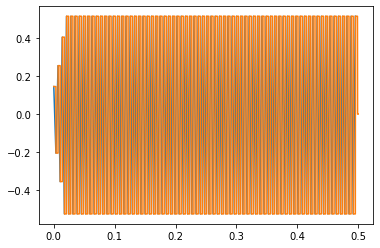

In [46]:
p = np.zeros_like(compute_time)
u = np.zeros_like(compute_time)

indT = int(T*fe)

gamma = 0.5
zeta = 0.4
tab_p, tab_F = tableau_F(-1,1,200,gamma,zeta)
solvF = tab_p - tab_F

i_act = np.argmin(np.abs(tab_p-gamma)) + 1

ibis = find_zero(solvF,i_act)

#plt.figure(figsize=(8,5))
#plt.plot(tab_p,tab_F)
#plt.plot(tab_p,solvF)
#plt.plot(tab_p[i_act],tab_F[i_act],'+')
#plt.plot(tab_p[ibis],tab_F[ibis],'+')
r_dt = np.array([0,0,-1])

for j in range(len(p)):
    ph = -(p[j-1]+Z*u[j-1])   # cas avec  
    #indT = len(r_dt)-1
    #if j<indT:
    #    ph = np.sum((p[0:j]+Z*u[0:j])*r_dt[j:0:-1])
    #else:
    #    ph = np.sum((p[j-indT:j]+Z*u[j-indT:j])*r_dt[indT:0:-1])
    i = find_zero(solvF-ph,i_act)
    i_act = i
    p[j] = tab_p[i]
    u[j] = tab_F[i]
    
p_final = np.zeros(len(sim_time))
u_final = np.zeros(len(sim_time))
i = 0
ind = 0
while i < Nsim and ind < Ncompute:
    p_final[i] = p[ind]
    u_final[i] = u[ind]
    i += 1
    time = i / fe
    ind = int(time // T)
    
plt.plot(compute_time,p)
plt.plot(sim_time,p_final)